In [156]:
import matplotlib.pyplot as plt

In [157]:
import matplotlib.pyplot as plt
import numpy as np

In [158]:
%load_ext autoreload

%autoreload 2

from pathlib import Path
from bs_fdbck.util.BSOA_datamanip import ds2df_inc_preprocessing, ds2df_echam
from bs_fdbck.util.collocate.collocateLONLAToutput import CollocateLONLATout
from bs_fdbck.util.collocate.collocate_echam_salsa import CollocateModelEcham
import useful_scit.util.log as log
from bs_fdbck.util.plot.BSOA_plots import make_cool_grid, plot_scatter
log.ger.setLevel(log.log.INFO)
import time
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
select_station = 'SMR'
model_level_i = -1

In [160]:
plot_path = Path(f'Plots/Both_stations')

In [161]:
def make_fn_scat(case, v_x, v_y):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'scat_all_years_2stations_{case}_{_x}_{_y}.png'
    return plot_path /f

In [162]:
models = ['ECHAM-SALSA','NorESM', 'EC-Earth', 'UKESM']
mod2cases = {'ECHAM-SALSA' : ['SALSA_BSOA_feedback'],
             'NorESM' : ['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth' : ['ECE3_output_Sara'],
             'UKESM' : ['AEROCOMTRAJ'],
             'Observations':['Obs'],
            }
di_mod2cases = mod2cases.copy()

In [163]:
models_and_obs =  models + ['Observations'] 
models_and_obs

['ECHAM-SALSA', 'NorESM', 'EC-Earth', 'UKESM', 'Observations']

In [164]:
dic_season_nicename = {
    'JFM':'Jan-Mar',
    'FMA':'Feb-Apr',
    'FMAM':'Feb-May',
    'JFMAM':'Jan-May',
    'MAM':'Mar-May',
    'JA':'July-Aug',
}


## Read in data

In [165]:
path_save_daily_medians_SMR = Path(f'Temp_data/SMR_daily_medians')
path_save_daily_medians_ATTO = Path(f'Temp_data/ATTO_daily_medians')

dic_df_med_SMR = dict()
dic_df_med_ATTO = dict()

for mo in di_mod2cases.keys():
    for ca in di_mod2cases[mo]:
        if len(di_mod2cases[mo])>1:
            use_name = f'{mo}_{ca}'
        else:
            use_name = mo
            
        
        fp_smr = path_save_daily_medians_SMR.parent / f'{path_save_daily_medians_SMR.name}_{use_name}.csv'
        fp_atto = path_save_daily_medians_ATTO.parent / f'{path_save_daily_medians_ATTO.name}_{use_name}.csv'
        
        dic_df_med_SMR[use_name] = pd.read_csv(fp_smr, index_col=0,)
        dic_df_med_SMR[use_name].index = pd.to_datetime(dic_df_med_SMR[use_name].index)
        dic_df_med_SMR[use_name]['month'] = dic_df_med_SMR[use_name].index.month
        dic_df_med_ATTO[use_name] = pd.read_csv(fp_atto, index_col=0)
        dic_df_med_ATTO[use_name].index = pd.to_datetime(dic_df_med_ATTO[use_name].index)
        dic_df_med_ATTO[use_name]['month'] = dic_df_med_ATTO[use_name].index.month
        
        


In [166]:
def make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.4,
             source_list = models_and_obs, fig=None, 
               axs=None,
              xscale='linear', yscale='linear',
               select_station= '',
              dic_df_med = None,
               divide_NorESM_by_factor=None,
               markersize = 1,
             ):
    if xlab is None: 
        if xlab in label_dic:
            xlab = label_dic[v_x]
    if ylab is None: 
        if ylab in label_dic:
            ylab = label_dic[v_y]

    for mo, ax in zip(source_list, axs[:]):
        print(mo)
        df_s =  dic_df_med[mo]
    
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            title = f'{mo}/{divide_NorESM_by_factor}'
            print(title)
            ax.spines['bottom'].set_color('r')
            ax.spines['top'].set_color('r') 
            ax.spines['right'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.set_title(title, c='r')

        else:
            title = mo
            ax.set_title(title,)# y=.95)
            
        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt+.1, 
                    label='__nolegend__',
                    ax = ax,
                    #facecolor='none',
                        edgecolor=cdic_model[mo],
                        marker='.',
                        #size=markersize,
                        #rasterized = True,
                    
                   )
        #ax.set_title(mo, y=.95)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    fig.suptitle(f'{select_station}, {season} season, 2012-2018', y=.95)
    #xlim_dist = list(daxs['y'].get_xlim())
    for mo,ax in zip(source_list, axs):

        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if xscale=='log':
            xbins = np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),20)
        else:
            xbins = np.linspace(xlims[0],xlims[1],20)
            
        if yscale=='log':
            ybins = np.logspace(np.log10(ylims[0]),np.log10(ylims[1]),20)
        else:
            ybins = np.linspace(ylims[0],ylims[1],20)
            

        ax.set_ylim(ylims)
        ax.set_xlim(xlims)

        sns.despine(ax = ax)

    return

#### WET_mid

### Fit funcs

In [167]:
from bs_fdbck.util.BSOA_datamanip.fits import *
from bs_fdbck.util.BSOA_datamanip.atto import season2month

### season to monthseason2month

In [168]:
from sklearn.metrics import r2_score


In [169]:
def select_months(df, season = None, month_list=None):
    if season is not None: 
        month_list = season2month[season]
    

    df['month'] = df.index.month
    return df['month'].isin(month_list)

In [170]:
from bs_fdbck.util.BSOA_datamanip.fits import *

In [171]:
from bs_fdbck.util.plot.BSOA_plots import cdic_model, make_cool_grid5

In [172]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [173]:
def func_smr(df_s,v_x,v_y,):
    if v_y=='N50':
        return get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    elif v_y =='N100':
        try:
            return get_log_fit_abc(df_s,v_x,v_y, return_func=True)
        except RuntimeError:
            return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
            
    elif v_y =='N200':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
    else:
        print(f'did not recognice v_y:{v_y}')


In [174]:
def calc_table_se(di):
    di['a'] = di['popt'][0]
    di['b'] = di['popt'][1]
    if len(di['popt'])>2:
        di['c'] = di['popt'][2]
    di['SE_a'] = di['standard_error'][0]
    di['SE_b'] = di['standard_error'][1]
    if len(di['popt'])>2:
        di['SE_c'] = di['standard_error'][2]
    else:
        di['SE_c'] = np.nan
        
    for v in ['a','b','c']:
        if len(di['popt'])<=2 and v=='c':
            di[f'{v}_str'] = ''
            continue
        v_SE = f'SE_{v}'
        if np.abs(di[v])>10 and di[v_SE]>1:
            di[f'{v}_str'] = '%.1f $\pm$ %.1f' %(di[v], di[v_SE])
        elif np.abs(di[v])>.1 and di[v_SE]>.01:
            di[f'{v}_str'] = '%.2f $\pm$ %.2f' %(di[v], di[v_SE])
        else:
            di[f'{v}_str'] = '%.2E $\pm$ %.2E' %(di[v], di[v_SE])
            
            

    return di

In [175]:
def func_atto(df_s,v_x,v_y,):
    if v_y=='N50-500':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    elif v_y =='N100-500':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)

    elif v_y =='N200-500':
        return get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
    else:
        print(f'did not recognice v_y:{v_y}')


In [176]:
def get_r2(df_s,v_x,x_y, popt, func):
    
    _df = df_s[[v_x, v_y]].dropna()
    y_pred = func(_df[v_x].values, *popt)
    r2 =  r2_score(_df[v_y].values, y_pred)
    return r2



In [177]:
def make_pd_of_dic(dic_fits):
    columns = ['station','variable','data source','Fit','a','b','c','r2']
    df_test = pd.DataFrame(columns=columns )
    df_list = []
    dic_labels = dict()
    for st in ['SMR','ATTO']:
        dic_labels[st] = dict()
        for v_y in dic_fits[st].keys():
            dic_labels[st][v_y] = dict()
            for mo in dic_fits[st][v_y].keys():
                dic_labels[st][v_y][mo] = dict()
                dic_labels[st][v_y][mo] = dic_fits[st][v_y][mo]['label'] 
                _d = dict()
                _d['station'] = st
                _d['variable'] =v_y
                _d['data source'] = mo
                _d['Fit'] = dic_fits[st][v_y][mo]['label']
                _d['a'] = dic_fits[st][v_y][mo]['a_str']
                _d['b'] = dic_fits[st][v_y][mo]['b_str']
                _d['c'] = dic_fits[st][v_y][mo]['c_str']
                _d['r$^2$'] = np.round(dic_fits[st][v_y][mo]['r2'] , decimals=2)
                #print(_d)
                d2 = {st:_d}
                df_list.append(pd.DataFrame(d2).T)
                

    df = pd.DataFrame(dic_labels['SMR']).T
    df['station'] = 'SMR'
    df2 = pd.DataFrame(dic_labels['ATTO']).T
    df2['station'] = 'ATTO'
    df2 = df2.reset_index().set_index(['station','index'])
    df1 = df.reset_index().set_index(['station','index'])
    df_out = pd.concat([df1,df2],)
    df_out = pd.concat(df_list, axis=0).reset_index()    
    df_out = df_out.drop('index', axis=1).set_index(['station','variable','data source'])
    return df_out



In [178]:
plot_path.mkdir(exist_ok=True)

In [179]:
left, width = .1, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.3260419965313248
UKESM
0.7071784273693082
EC-Earth
0.7055704375866648
NorESM
0.8673123336579371
ECHAM-SALSA


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x

0.43915906482691647
Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.7654555486539522
UKESM
0.7690390842823331
EC-Earth
0.8586986436494548
NorESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


[301.02217349 -40.08380808]
Beta: [309.70507581 -56.8184447 ]
Beta Std Error: [ 4.74766971 11.49313528]
Beta Covariance: [[  797.38462949 -1536.80607688]
 [-1536.80607688  4672.87216661]]
Residual Variance: 0.028267873327671555
Inverse Condition #: 0.21584338153971055
Reason(s) for Halting:
  Sum of squares convergence
[309.70507581 -56.8184447 ]
reason for haltng
0.9439276689267722
ECHAM-SALSA
0.7815120149772352
Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
[51.33455418 -2.93983954]
Beta: [ 54.27778214 -11.5280681 ]
Beta Std Error: [1.16494125 3.986287  ]
Beta Covariance: [[ 24.8211844  -72.4273085 ]
 [-72.4273085  290.63745365]]
Residual Variance: 0.05467459151999246
Inverse Condition #: 0.00869246861927541
Reason(s) for Halting:
  Sum of squares convergence
[ 54.27778214 -11.5280681 ]
reason for haltng
0.8915472544405885
UKESM
[128.15001338  77.98550035]
Beta: [131.23630057  69.71122447]
Beta Std Error: [1.84809243 6.15685835]
Beta Covariance: [[ 144.03220451 -386.1474

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


 0.04728226345806013
Inverse Condition #: 0.17441809383449478
Reason(s) for Halting:
  Sum of squares convergence
[42.03663846 13.61756876]
reason for haltng
0.9062761641808321
NorESM
[26.3398952   5.96112264]
Beta: [29.48973229 -0.10939951]
Beta Std Error: [0.90060005 2.16410045]
Beta Covariance: [[  7.53082781 -14.51399008]
 [-14.51399008  43.48441293]]
Residual Variance: 0.10770136764734853
Inverse Condition #: 0.21366159406204432
Reason(s) for Halting:
  Sum of squares convergence
[29.48973229 -0.10939951]
reason for haltng
0.7863645970735378
ECHAM-SALSA
[32.06152065  3.29858087]
Beta: [35.50844359 -0.98086904]
Beta Std Error: [1.0310883  1.61759544]
Beta Covariance: [[ 10.86206609 -13.48553664]
 [-13.48553664  26.73379123]]
Residual Variance: 0.0978766898075105
Inverse Condition #: 0.3056045355094191
Reason(s) for Halting:
  Sum of squares convergence
[35.50844359 -0.98086904]
reason for haltng
0.8058513910669727
Observations
UKESM
EC-Earth
NorESM
NorESM/4
ECHAM-SALSA
Observations

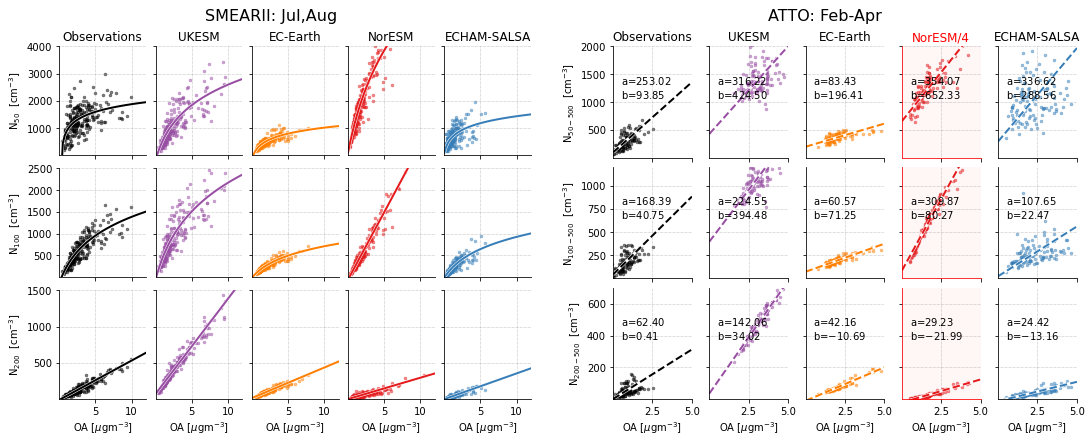

In [209]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[15,6],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          width_ratios=[4,.1,4],
                          height_ratios=[1,20], 
                          figure=fig_main)

markersize = 5

subfig1 =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig2 =  fig_main.add_subfigure(spec2[1, 1])
subfig3 =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up =  fig_main.add_subfigure(spec2[0, :])


axs_smr = subfig1.subplots(3,5, sharex='col', sharey='row')
#ax_fits = subfig2.subplots(3,1, sharex='col', sharey='row')
axs_atto =subfig3.subplots(3,5, sharex='col', sharey='row')
#subfig2.set_facecolor('#e9f2f9')##e5f8f8')
# subfig3.set_facecolor('#fff4ea')

dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()

#subfig1.suptitle('SMEARII, Jul & Aug')
#subfig3.suptitle('ATTO, JFM')
#subfig2.suptitle('Fits')

ax_dum = subfig_up.subplots(1)
ax_dum.axis('off')


divide_NorESM_by_factor = 4


varlistplot = ['N50','N100','N200']
xlab = r'OA [$\mu$gm$^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,12], 'ylims':[1,4000]},
    'N100': {'xlims':[.01,12], 'ylims':[1,2500]},
    'N200': {'xlims':[.01,12], 'ylims':[1,1500]},
    'N50-500': {'xlims':[.01,5], 'ylims':[1,2000]},
    'N100-500': {'xlims':[.01,5], 'ylims':[1,1200]},
    'N200-500': {'xlims':[.01,5], 'ylims':[1,700]},

}

dic_ylabels = {
    'N50' : r'N$_{50}$  [cm$^{-3}$]',
    'N100' : r'N$_{100}$  [cm$^{-3}$]',
    'N200' : r'N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'N$_{200-500}$  [cm$^{-3}$]',

}




select_station = 'SMR'
season = 'JA'


xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_SMR
axs_all = axs_smr
fig = subfig1


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings
legends_smr = []
legends_atto = []
legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)
    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               markersize=markersize,
         )

    
    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()

        df_s =  dic_df_med[mo]
        
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        popt, pov, label, func = func_smr(df_s,v_x,v_y)
            
            
        legends_smr.append(label)

        plot_fit(func, popt, mo, xlims, yscale, xscale, ax, label,)
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,extra_plot=True)

        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['r2'] = get_r2(df_s,v_x,v_y, popt, func)
        print( get_r2(df_s,v_x,v_y, popt, func))
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   
        
        
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 








varlistplot = ['N50-500','N100-500','N200-500']

select_station = 'ATTO'
season = 'FMA'

xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_ATTO
axs_all = axs_atto
fig = subfig3
select_station = 'ATTO'


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings

legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)

    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               divide_NorESM_by_factor=divide_NorESM_by_factor,
         )


    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()
        
        df_s =  dic_df_med[mo]
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
    
        popt, pov, label, func = func_atto(df_s,v_x,v_y)
        legends_atto.append(label)
        
        plot_fit(func, popt, mo, xlims, yscale, xscale, ax,label, linestyle='dashed')
        #plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,  extra_plot=True,linestyle='dashed',)
        ax.set_xlim(xlims)
        #dic_fits['ATTO'][v_y][mo]['label'] = label
        #dic_fits['ATTO'][v_y][mo]['popt'] = popt
        #dic_fits['ATTO'][v_y][mo]['pov'] = pov 
        
        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        #dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['r2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])        

        _a = label.split('x')[0][1:]
        _b = label.split('x')[1][:-1]
        if _b[0]=='+':
            _b=_b[1:]
        ax.text(left, top, f'a=${_a}$ \nb=${_b}$',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
        #ax.legend(frameon=False, fontsize=10)
    
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 




#for i, v_y in enumerate(varlistplot):
#    xlims = dic_lims[v_y]['xlims']
#    ax = ax_fits[i]
    
    #ax.set_xlim(xlims)
#    ax.set_ylim(dic_lims[v_y]['ylims'])
#    ax.set_yticklabels([])
#    ax.set_facecolor('#e9f2f9')##e5f8f8')
#    sns.despine(ax)
#ax.set_xlabel(xlab)
sns.despine(subfig2) 

subfig1.suptitle('SMEARII: Jul,Aug', size=16, y=1.05)
subfig2.suptitle('Fits', size=16, y=1.05, c='w')
subfig3.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.05)

#axs_all = list(ax_fits.flatten())+list(axs_smr.flatten())+ list(axs_atto.flatten())
axs_all = list(list(axs_smr.flatten())+ list(axs_atto.flatten()))
for ax in axs_all:
    ax.grid(color = 'grey', linestyle = ':', linewidth = 0.5)



#for ax in axs_atto[:,0]:
#    ax.set_yticklabels([])
#    ax.set_ylabel('')

for ax in axs_atto[1:,:].flatten():
    ax.set_title('')


for ax in axs_smr[1:,:].flatten():
    ax.set_title('')

#ax_fits[0].set_title('.', color='w')
fn = make_fn_scat(f'together_{season}', v_x, 'Nx')
print(fn)
plt.savefig(fn.with_suffix('.pdf'),bbox_inches='tight', dpi=200)
plt.savefig(fn.with_suffix('.png'),bbox_inches='tight', dpi=200)

df = make_pd_of_dic(dic_fits)
df_log = df
df.to_csv(fn.with_suffix('.csv'))

plt.show()

In [208]:
df

Fit  \
station variable data source                                       
SMR     N50      Observations     $ 979.97 + 393.47\ln(-0.24+x)$   
                 UKESM          $ -536.09 + 1290.16\ln( 1.30+x)$   
                 EC-Earth         $ 243.32 + 329.52\ln( 0.27+x)$   
                 NorESM        $ -2926.11 + 3378.41\ln( 2.44+x)$   
                 ECHAM-SALSA      $ 535.47 + 384.67\ln( 0.30+x)$   
        N100     Observations    $ -473.57 + 760.26\ln( 1.54+x)$   
                 UKESM          $ -817.07 + 1207.13\ln( 1.86+x)$   
                 EC-Earth        $ -274.80 + 397.04\ln( 1.90+x)$   
                 NorESM                        $309.71x+ -56.82$   
                 ECHAM-SALSA     $ -360.79 + 518.61\ln( 1.94+x)$   
        N200     Observations                   $54.28x+ -11.53$   
                 UKESM                          $131.24x+ 69.71$   
                 EC-Earth                        $42.04x+ 13.62$   
                 NorESM                          $29.49x+ -0.11$   
                 ECHAM-SALSA                     $35.51x+ -0.98$   
ATTO    N50-500  Observations                   $253.02x+ 93.85$   
                 UKESM                         $316.22x+ 424.50$   
                 EC-Earth                       $83.43x+ 196.41$   
                 NorESM                        $354.07x+ 652.33$   
                 ECHAM-SALSA                   $336.62x+ 288.56$   
        N100-500 Observations                   $168.39x+ 40.75$   
                 UKESM                         $224.55x+ 394.48$   
                 EC-Earth                        $60.57x+ 71.25$   
                 NorESM                         $309.87x+ 80.27$   
                 ECHAM-SALSA                    $107.65x+ 22.47$   
        N200-500 Observations                    $62.40x+  0.41$   
                 UKESM                          $142.06x+ 34.02$   
                 EC-Earth                       $42.16x+ -10.69$   
                 NorESM                         $29.23x+ -21.99$   
                 ECHAM-SALSA                    $24.42x+ -13.16$   

                                                  a                   b  \
station variable data source                                              
SMR     N50      Observations      980.0 $\pm$ 93.3    393.5 $\pm$ 65.9   
                 UKESM           -536.1 $\pm$ 554.1  1290.2 $\pm$ 230.9   
                 EC-Earth         243.3 $\pm$ 105.3    329.5 $\pm$ 56.7   
                 NorESM        -2926.1 $\pm$ 1251.0  3378.4 $\pm$ 487.6   
                 ECHAM-SALSA      535.5 $\pm$ 127.2    384.7 $\pm$ 92.8   
        N100     Observations    -473.6 $\pm$ 300.9   760.3 $\pm$ 122.2   
                 UKESM           -817.1 $\pm$ 538.0  1207.1 $\pm$ 209.9   
                 EC-Earth        -274.8 $\pm$ 176.3    397.0 $\pm$ 71.5   
                 NorESM            309.7 $\pm$ 28.2    -56.8 $\pm$ 68.4   
                 ECHAM-SALSA     -360.8 $\pm$ 251.8   518.6 $\pm$ 112.0   
        N200     Observations        54.3 $\pm$ 5.0    -11.5 $\pm$ 17.0   
                 UKESM             131.2 $\pm$ 12.0     69.7 $\pm$ 40.0   
                 EC-Earth            42.0 $\pm$ 4.0     13.6 $\pm$ 10.0   
                 NorESM              29.5 $\pm$ 2.7    -0.11 $\pm$ 6.59   
                 ECHAM-SALSA         35.5 $\pm$ 3.3    -0.98 $\pm$ 5.17   
ATTO    N50-500  Observations      253.0 $\pm$ 37.1     93.8 $\pm$ 34.5   
                 UKESM             316.2 $\pm$ 49.9   424.5 $\pm$ 163.3   
                 EC-Earth           83.4 $\pm$ 11.7    196.4 $\pm$ 26.2   
                 NorESM            354.1 $\pm$ 48.2    652.3 $\pm$ 90.0   
                 ECHAM-SALSA       336.6 $\pm$ 55.2   288.6 $\pm$ 135.6   
        N100-500 Observations      168.4 $\pm$ 24.8     40.7 $\pm$ 23.0   
                 UKESM             224.6 $\pm$ 31.9   394.5 $\pm$ 104.8   
                 EC-Earth            60.6 $\pm$ 8.1     71.2 $\pm$ 18.2   
         

In [ ]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[15,6],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          width_ratios=[4,1,4],
                          height_ratios=[1,20], 
                          figure=fig_main)

markersize = 5

subfig1 =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig2 =  fig_main.add_subfigure(spec2[1, 1])
subfig3 =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up =  fig_main.add_subfigure(spec2[0, :])


axs_smr = subfig1.subplots(3,5, sharex='col', sharey='row')
ax_fits = subfig2.subplots(3,1, sharex='col', sharey='row')
axs_atto =subfig3.subplots(3,5, sharex='col', sharey='row')
subfig2.set_facecolor('#e9f2f9')##e5f8f8')
# subfig3.set_facecolor('#fff4ea')

dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()

#subfig1.suptitle('SMEARII, Jul & Aug')
#subfig3.suptitle('ATTO, JFM')
#subfig2.suptitle('Fits')

ax_dum = subfig_up.subplots(1)
ax_dum.axis('off')


divide_NorESM_by_factor = 4


varlistplot = ['N50','N100','N200']
xlab = r'OA [$\mu$gm$^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,12], 'ylims':[1,4000]},
    'N100': {'xlims':[.01,12], 'ylims':[1,2500]},
    'N200': {'xlims':[.01,12], 'ylims':[1,1500]},
    'N50-500': {'xlims':[.01,5], 'ylims':[1,2000]},
    'N100-500': {'xlims':[.01,5], 'ylims':[1,1000]},
    'N200-500': {'xlims':[.01,5], 'ylims':[1,1000]},

}

dic_ylabels = {
    'N50' : r'N$_{50}$  [cm$^{-3}$]',
    'N100' : r'N$_{100}$  [cm$^{-3}$]',
    'N200' : r'N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'N$_{200-500}$  [cm$^{-3}$]',

}




select_station = 'SMR'
season = 'JA'


xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_SMR
axs_all = axs_smr
fig = subfig1


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings
legends_smr = []
legends_atto = []
legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)
    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               markersize=markersize,
         )

    
    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()

        df_s =  dic_df_med[mo]
        
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        popt, pov, label, func = func_smr(df_s,v_x,v_y)
            
            
        legends_smr.append(label)

        plot_fit(func, popt, mo, xlims, yscale, xscale, ax, label,)
        plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,extra_plot=True)

        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['r2'] = get_r2(df_s,v_x,v_y, popt, func)
        print( get_r2(df_s,v_x,v_y, popt, func))
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   
        
        
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 








varlistplot = ['N50-500','N100-500','N200-500']

select_station = 'ATTO'
season = 'FMA'

xscale='linear'
yscale='linear'


# OBS: 

dic_df_med = dic_df_med_ATTO
axs_all = axs_atto
fig = subfig3
select_station = 'ATTO'


#fig, axs_all = plt.subplots(3,6,figsize=figsize, sharey='row', sharex='col')
## Settings

legs =[]

for i,v_y in enumerate(varlistplot):
    dic_fits[select_station][v_y] = dict()
    
    # Make plot
    ylab = dic_ylabels[v_y]
    ylims = dic_lims[v_y]['ylims']
    xlims = dic_lims[v_y]['xlims']
    axs_sub = axs_all[i,:]
    axs_sub[0].set_ylabel(ylab)

    make_plot2(v_x, v_y, xlims, ylims, season, 
              xlab=xlab, ylab=ylab, alpha_scat=alpha_scatt,
             source_list = source_list, fig=fig, 
               axs=axs_sub,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
           select_station= select_station,
               divide_NorESM_by_factor=divide_NorESM_by_factor,
         )


    for mo, ax in zip(source_list, axs_sub):
        dic_fits[select_station][v_y][mo] = dict()
        
        df_s =  dic_df_med[mo]
        print(mo)
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
    
        popt, pov, label, func = func_atto(df_s,v_x,v_y)
        legends_atto.append(label)
        
        plot_fit(func, popt, mo, xlims, yscale, xscale, ax,label, linestyle='dashed')
        plot_fit(func, popt, mo, xlims, yscale, xscale,  ax_fits[i],label,  extra_plot=True,linestyle='dashed',)
        ax.set_xlim(xlims)
        #dic_fits['ATTO'][v_y][mo]['label'] = label
        #dic_fits['ATTO'][v_y][mo]['popt'] = popt
        #dic_fits['ATTO'][v_y][mo]['pov'] = pov 
        
        dic_fits[select_station][v_y][mo]['label'] = label
        dic_fits[select_station][v_y][mo]['popt'] = popt
        dic_fits[select_station][v_y][mo]['pcov'] = pov
        dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))
        
        #dic_fits[select_station][v_y][mo]['func'] = func
        dic_fits[select_station][v_y][mo]['r2'] = get_r2(df_s,v_x,v_y, popt, func)
        dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])        

        _a = label.split('x')[0][1:]
        _b = label.split('x')[1][:-1]
        if _b[0]=='+':
            _b=_b[1:]
        ax.text(left, top, f'a=${_a}$ \nb=${_b}$',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

        ax.set_yscale(yscale)
        ax.set_xscale(xscale)
        #ax.legend(frameon=False, fontsize=10)
    
    #leg = axs_sub[-1].legend(bbox_to_anchor=(1,1,), frameon=False)

    #legs.append(leg)


    
for ax in axs_sub:
    ax.set_xlabel(xlab)
sns.despine(fig) 




for i, v_y in enumerate(varlistplot):
    xlims = dic_lims[v_y]['xlims']
    ax = ax_fits[i]
    
    #ax.set_xlim(xlims)
    ax.set_ylim(dic_lims[v_y]['ylims'])
    ax.set_yticklabels([])
    ax.set_facecolor('#e9f2f9')##e5f8f8')
#    sns.despine(ax)
ax.set_xlabel(xlab)
sns.despine(subfig2) 

subfig1.suptitle('SMEARII: Jul,Aug', size=16, y=1.05)
subfig2.suptitle('Fits', size=16, y=1.05, c='w')
subfig3.suptitle(f'ATTO: {dic_season_nicename[season]}', size=16, y=1.05)

axs_all = list(ax_fits.flatten())+list(axs_smr.flatten())+ list(axs_atto.flatten())
for ax in axs_all:
    ax.grid(color = 'grey', linestyle = ':', linewidth = 0.5)



#for ax in axs_atto[:,0]:
#    ax.set_yticklabels([])
#    ax.set_ylabel('')

for ax in axs_atto[1:,:].flatten():
    ax.set_title('')


for ax in axs_smr[1:,:].flatten():
    ax.set_title('')

ax_fits[0].set_title('.', color='w')
fn = make_fn_scat(f'together_{season}', v_x, 'Nx')
print(fn)
plt.savefig(fn.with_suffix('.pdf'),bbox_inches='tight', dpi=200)
plt.savefig(fn.with_suffix('.png'),bbox_inches='tight', dpi=200)

df = make_pd_of_dic(dic_fits)
df_log = df
df.to_csv(fn.with_suffix('.csv'))

plt.show()

Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.3260419965313248
UKESM
0.7071784273693082
EC-Earth
0.7055704375866648
NorESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x

0.8673123336579371
ECHAM-SALSA
0.43915906482691647
Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
0.7654555486539522
UKESM
0.7690390842823331
EC-Earth
0.8586986436494548
NorESM


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


[301.02217349 -40.08380808]
Beta: [309.70507581 -56.8184447 ]
Beta Std Error: [ 4.74766971 11.49313528]
Beta Covariance: [[  797.38462949 -1536.80607688]
 [-1536.80607688  4672.87216661]]
Residual Variance: 0.028267873327671555
Inverse Condition #: 0.21584338153971055
Reason(s) for Halting:
  Sum of squares convergence
[309.70507581 -56.8184447 ]
reason for haltng
0.9439276689267722
ECHAM-SALSA
0.7815120149772352
Observations
UKESM
EC-Earth
NorESM
ECHAM-SALSA
Observations
[51.33455418 -2.93983954]
Beta: [ 54.27778214 -11.5280681 ]
Beta Std Error: [1.16494125 3.986287  ]
Beta Covariance: [[ 24.8211844  -72.4273085 ]
 [-72.4273085  290.63745365]]
Residual Variance: 0.05467459151999246
Inverse Condition #: 0.00869246861927541
Reason(s) for Halting:
  Sum of squares convergence
[ 54.27778214 -11.5280681 ]
reason for haltng
0.8915472544405885
UKESM
[128.15001338  77.98550035]
Beta: [131.23630057  69.71122447]
Beta Std Error: [1.84809243 6.15685835]
Beta Covariance: [[ 144.03220451 -386.1474

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


[40.06676866 17.81861249]
Beta: [42.03663846 13.61756876]
Beta Std Error: [0.87206592 2.17410458]
Beta Covariance: [[ 16.08423364 -34.30205052]
 [-34.30205052  99.96836803]]
Residual Variance: 0.04728226345806013
Inverse Condition #: 0.17441809383449478
Reason(s) for Halting:
  Sum of squares convergence
[42.03663846 13.61756876]
reason for haltng
0.9062761641808321
NorESM
[26.3398952   5.96112264]
Beta: [29.48973229 -0.10939951]
Beta Std Error: [0.90060005 2.16410045]
Beta Covariance: [[  7.53082781 -14.51399008]
 [-14.51399008  43.48441293]]
Residual Variance: 0.10770136764734853
Inverse Condition #: 0.21366159406204432
Reason(s) for Halting:
  Sum of squares convergence
[29.48973229 -0.10939951]
reason for haltng
0.7863645970735378
ECHAM-SALSA
[32.06152065  3.29858087]
Beta: [35.50844359 -0.98086904]
Beta Std Error: [1.0310883  1.61759544]
Beta Covariance: [[ 10.86206609 -13.48553664]
 [-13.48553664  26.73379123]]
Residual Variance: 0.0978766898075105
Inverse Condition #: 0.30560453

### Residual SMR ln

ECHAM-SALSA
NorESM
EC-Earth
UKESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


Plots/Both_stations/scat_all_years_2stations_residual_ln_JA_SMR_OA_N50.png


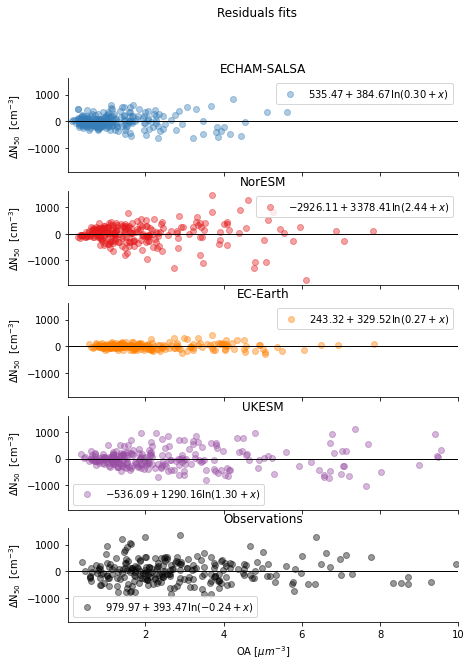

ECHAM-SALSA
NorESM
[301.02217349 -40.08380808]
Beta: [309.70507581 -56.8184447 ]
Beta Std Error: [ 4.74766971 11.49313528]
Beta Covariance: [[  797.38462949 -1536.80607688]
 [-1536.80607688  4672.87216661]]
Residual Variance: 0.028267873327671555
Inverse Condition #: 0.21584338153971055
Reason(s) for Halting:
  Sum of squares convergence
[309.70507581 -56.8184447 ]
reason for haltng
EC-Earth
UKESM
Observations


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/util/BSOA_datamanip/fits.py:528: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(c + x)


Plots/Both_stations/scat_all_years_2stations_residual_ln_JA_SMR_OA_N100.png


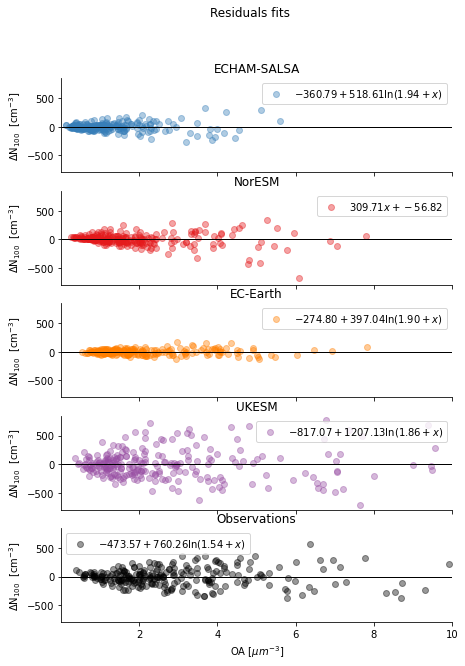

In [182]:
select_station = 'SMR'

figsize=[7,10]
## Settings
alpha_scatt = 0.5


divide_NorESM_by_factor = 2


varlistplot = ['N50','N100']
xlab = r'OA [$\mu m^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200': {'xlims':[.01,10], 'ylims':[1,200]},
    'N50-500': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100-500': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200-500': {'xlims':[.01,10], 'ylims':[1,200]},

}

dic_ylabels = {
    'N50' : r'$\Delta$N$_{50}$  [cm$^{-3}$]',
    'N100' : r'$\Delta$N$_{100}$  [cm$^{-3}$]',
    'N200' : r'$\Delta$N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'$\Delta$N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'$\Delta$N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'$\Delta$N$_{200-500}$  [cm$^{-3}$]',

}






xscale='linear'
yscale='linear'


if select_station=='SMR':
    varlistplot = ['N50','N100']
    
    dic_df_med = dic_df_med_SMR
    season = 'JA'
    func_station = func_smr
    divide_NorESM_by_factor = None
    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    season = 'JFM'
    func_station = func_atto
    
    divide_NorESM_by_factor = 2
    varlistplot = ['N50-500','N100-500','N200-500']


for i,v_y in enumerate(varlistplot):
    #dic_fits[select_station][v_y] = dict()
    fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)
    
    for mo, ax in zip(models_and_obs, axs):

        df_s =  dic_df_med[mo]
        print(mo)
        
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
            title = f'{mo}/{divide_NorESM_by_factor}'
            print(title)
            ax.spines['bottom'].set_color('r')
            ax.spines['top'].set_color('r') 
            ax.spines['right'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.set_title(title, c='r')
        else:
            title=mo
            
            ax.set_title(title, )
    
        popt, pov, label, func = func_station(df_s,v_x,v_y)
        #legends_atto.append(label)


        _ma = df_s[v_x].max() 
        _mi = df_s[v_x].min() 
        ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
        #plt.show()
        xlims = dic_lims[v_y]['xlims']
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)


        ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
        ax.legend(frameon=False)
        ylab = dic_ylabels[v_y]
        ax.set_ylabel(ylab)
        ax.set_xlim(xlims)
        ax.legend(frameon=True)

        
    #fig.suptitle('Observations')
    axs[-1].set_xlabel(xlab)
    fig.suptitle(r'Residuals fits')

    sns.despine(fig)    
    
    fn = make_fn_scat(f'residual_ln_{season}_{select_station}', v_x, v_y)
    fig.savefig(fn, dpi=150)
    fig.savefig(fn.with_suffix('.pdf'), dpi=150)
    print(fn)
    plt.show()

### Residual SMR linear

ECHAM-SALSA
[202.02578986 388.34369982]
Beta: [325.16913944 235.45785051]
Beta Std Error: [20.20516015 30.80934736]
Beta Covariance: [[ 1069.13128717 -1327.35590416]
 [-1327.35590416  2485.83009792]]
Residual Variance: 0.3818506685595091
Inverse Condition #: 0.2918381802224606
Reason(s) for Halting:
  Sum of squares convergence
[325.16913944 235.45785051]
reason for haltng
NorESM
[636.05364632 678.20083413]
Beta: [697.5565595  559.66578104]
Beta Std Error: [19.26000393 46.36353851]
Beta Covariance: [[ 4172.35565051 -8041.41524457]
 [-8041.41524457 24178.07532348]]
Residual Variance: 0.08890607191936185
Inverse Condition #: 0.21419219425858624
Reason(s) for Halting:
  Sum of squares convergence
[697.5565595  559.66578104]
reason for haltng
EC-Earth
[116.69052702 242.69370474]
Beta: [144.58711229 183.20003921]
Beta Std Error: [ 6.3278951  15.61675128]
Beta Covariance: [[ 205.66919004 -438.62052507]
 [-438.62052507 1252.65675063]]
Residual Variance: 0.19469253676490797
Inverse Condition #

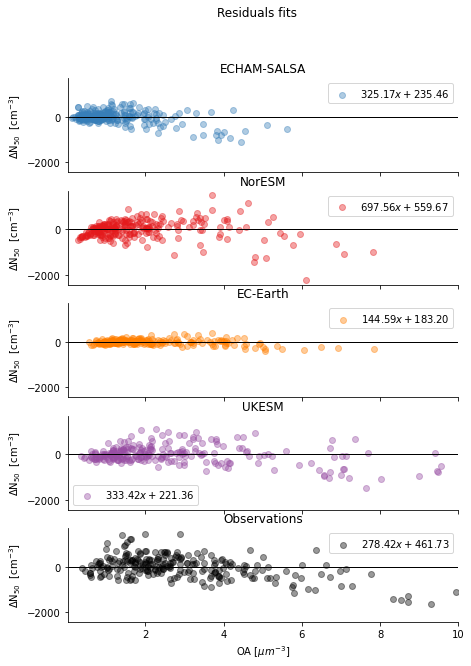

ECHAM-SALSA
[138.197521    48.04536519]
Beta: [158.46809548  22.87888004]
Beta Std Error: [5.32563625 8.3296595 ]
Beta Covariance: [[ 219.90211818 -273.0145604 ]
 [-273.0145604   537.94875925]]
Residual Variance: 0.1289773909924523
Inverse Condition #: 0.3042424801217555
Reason(s) for Halting:
  Sum of squares convergence
[158.46809548  22.87888004]
reason for haltng
NorESM
[301.02217349 -40.08380808]
Beta: [309.70507581 -56.8184447 ]
Beta Std Error: [ 4.74766971 11.49313528]
Beta Covariance: [[  797.38462949 -1536.80607688]
 [-1536.80607688  4672.87216661]]
Residual Variance: 0.028267873327671555
Inverse Condition #: 0.21584338153971055
Reason(s) for Halting:
  Sum of squares convergence
[309.70507581 -56.8184447 ]
reason for haltng
EC-Earth
[85.725572   78.82034842]
Beta: [93.79853321 61.60354232]
Beta Std Error: [2.66408607 6.62380013]
Beta Covariance: [[  81.72303184 -174.28666452]
 [-174.28666452  505.19890852]]
Residual Variance: 0.08684644279130965
Inverse Condition #: 0.1732612

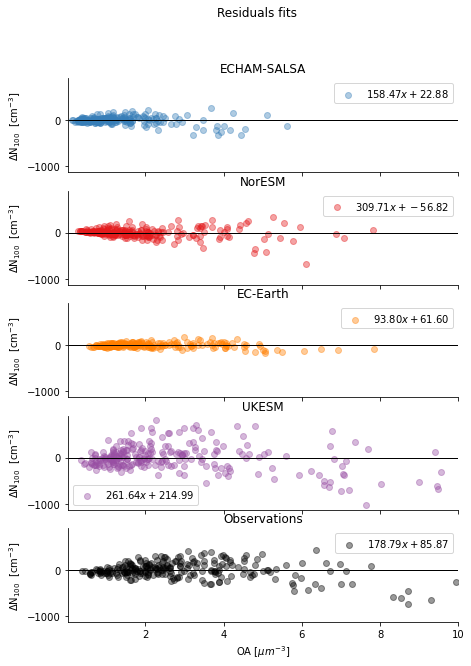

ECHAM-SALSA
[32.06152065  3.29858087]
Beta: [35.50844359 -0.98086904]
Beta Std Error: [1.0310883  1.61759544]
Beta Covariance: [[ 10.86206609 -13.48553664]
 [-13.48553664  26.73379123]]
Residual Variance: 0.0978766898075105
Inverse Condition #: 0.3056045355094191
Reason(s) for Halting:
  Sum of squares convergence
[35.50844359 -0.98086904]
reason for haltng
NorESM
[26.3398952   5.96112264]
Beta: [29.48973229 -0.10939951]
Beta Std Error: [0.90060005 2.16410045]
Beta Covariance: [[  7.53082781 -14.51399008]
 [-14.51399008  43.48441293]]
Residual Variance: 0.10770136764734853
Inverse Condition #: 0.21366159406204432
Reason(s) for Halting:
  Sum of squares convergence
[29.48973229 -0.10939951]
reason for haltng
EC-Earth
[40.06676866 17.81861249]
Beta: [42.03663846 13.61756876]
Beta Std Error: [0.87206592 2.17410458]
Beta Covariance: [[ 16.08423364 -34.30205052]
 [-34.30205052  99.96836803]]
Residual Variance: 0.04728226345806013
Inverse Condition #: 0.17441809383449478
Reason(s) for Haltin

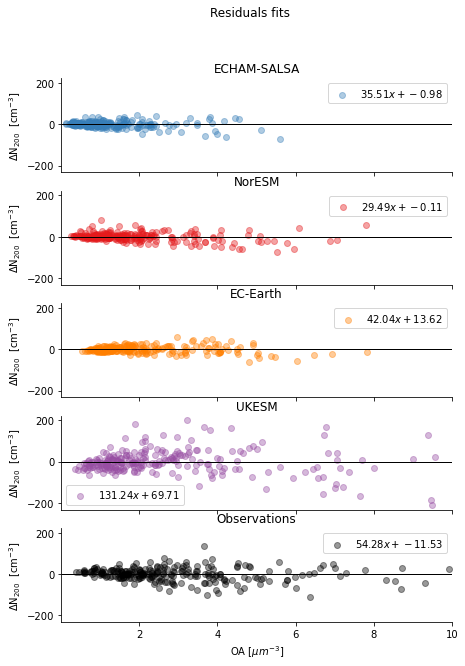

In [183]:
select_station = 'SMR'

## Settings
alpha_scatt = 0.5


divide_NorESM_by_factor = 2


varlistplot = ['N50','N100','N200']
xlab = r'OA [$\mu m^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200': {'xlims':[.01,10], 'ylims':[1,200]},
    'N50-500': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100-500': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200-500': {'xlims':[.01,10], 'ylims':[1,200]},

}

dic_ylabels = {
    'N50' : r'$\Delta$N$_{50}$  [cm$^{-3}$]',
    'N100' : r'$\Delta$N$_{100}$  [cm$^{-3}$]',
    'N200' : r'$\Delta$N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'$\Delta$N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'$\Delta$N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'$\Delta$N$_{200-500}$  [cm$^{-3}$]',

}






xscale='linear'
yscale='linear'


if select_station=='SMR':
    varlistplot = ['N50','N100','N200']
    
    dic_df_med = dic_df_med_SMR
    season = 'JA'
    func_station = func_smr
    divide_NorESM_by_factor = None
    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    season = 'JFM'
    func_station = func_atto
    
    divide_NorESM_by_factor = 2
    varlistplot = ['N50-500','N100-500','N200-500']


for i,v_y in enumerate(varlistplot):
    #dic_fits[select_station][v_y] = dict()
    fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)
    
    for mo, ax in zip(models_and_obs, axs):

        df_s =  dic_df_med[mo]
        print(mo)
        
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
            title = f'{mo}/{divide_NorESM_by_factor}'
            print(title)
            ax.spines['bottom'].set_color('r')
            ax.spines['top'].set_color('r') 
            ax.spines['right'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.set_title(title, c='r')
        else:
            title=mo
            
            ax.set_title(title, )
    
        #popt, pov, label, func = func_station(df_s,v_x,v_y)
        #legends_atto.append(label)
        popt, pov, label, func = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True)
        


        _ma = df_s[v_x].max() 
        _mi = df_s[v_x].min() 
        ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
        #plt.show()
        xlims = dic_lims[v_y]['xlims']
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)


        ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
        ax.legend(frameon=False)
        ylab = dic_ylabels[v_y]
        ax.set_ylabel(ylab)
        ax.set_xlim(xlims)
        ax.legend(frameon=True)

        
    #fig.suptitle('Observations')
    axs[-1].set_xlabel(xlab)
    fig.suptitle(r'Residuals fits')

    sns.despine(fig)    
    
    fn = make_fn_scat(f'residual_linear_{season}_{select_station}', v_x, v_y)
    fig.savefig(fn, dpi=150)
    fig.savefig(fn.with_suffix('.pdf'), dpi=150)
    print(fn)
    plt.show()

### Residual ATTO linear

ECHAM-SALSA
[ 87.01857548 862.76538066]
Beta: [336.6202089  288.56213686]
Beta Std Error: [ 47.98447514 117.81321069]
Beta Covariance: [[ 3052.30502242 -7021.76274776]
 [-7021.76274776 18399.85570344]]
Residual Variance: 0.7543511665219182
Inverse Condition #: 0.1124221902617027
Reason(s) for Halting:
  Sum of squares convergence
[336.6202089  288.56213686]
reason for haltng
NorESM
NorESM/4
[293.8762954 755.2965475]
Beta: [354.0668443  652.32653488]
Beta Std Error: [20.04001015 37.43369983]
Beta Covariance: [[ 2322.19984363 -3972.66602964]
 [-3972.66602964  8102.69001179]]
Residual Variance: 0.1729403297653696
Inverse Condition #: 0.16169002312696484
Reason(s) for Halting:
  Sum of squares convergence
[354.0668443  652.32653488]
reason for haltng
EC-Earth
[ 61.5213463  242.27321419]
Beta: [ 83.43341929 196.40869269]
Beta Std Error: [ 6.02397524 13.53852418]
Beta Covariance: [[ 135.82196117 -284.29118447]
 [-284.29118447  686.03502665]]
Residual Variance: 0.26717533324129733
Inverse Con

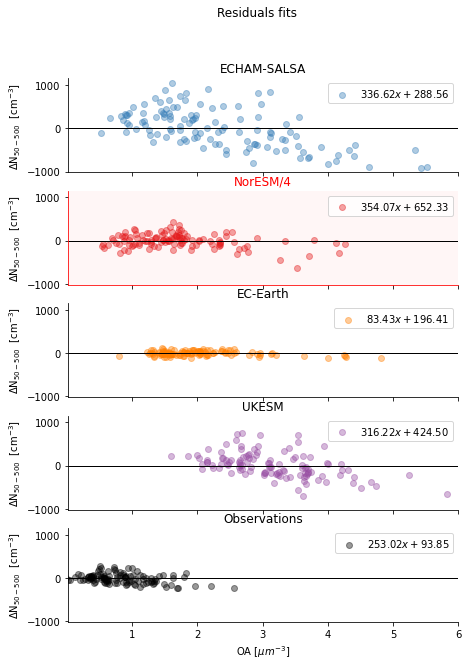

ECHAM-SALSA
[ 46.59159762 162.93370787]
Beta: [107.649599    22.47109152]
Beta Std Error: [12.57783815 31.14122731]
Beta Covariance: [[ 274.17460428 -630.73292552]
 [-630.73292552 1680.68634166]]
Residual Variance: 0.5770119113583498
Inverse Condition #: 0.1189564744083405
Reason(s) for Halting:
  Sum of squares convergence
[107.649599    22.47109152]
reason for haltng
NorESM
NorESM/4
[304.3754514   89.67160439]
Beta: [309.86867587  80.27416277]
Beta Std Error: [ 5.44176286 10.23288807]
Beta Covariance: [[ 1641.98928943 -2809.00679199]
 [-2809.00679199  5806.14052365]]
Residual Variance: 0.018034699272482357
Inverse Condition #: 0.1672245442414497
Reason(s) for Halting:
  Sum of squares convergence
[309.86867587  80.27416277]
reason for haltng
EC-Earth
[55.21326994 82.45706734]
Beta: [60.56821666 71.24854025]
Beta Std Error: [2.4189413  5.47245104]
Beta Covariance: [[  65.05419328 -136.16600633]
 [-136.16600633  332.95719756]]
Residual Variance: 0.08994465529157107
Inverse Condition #:

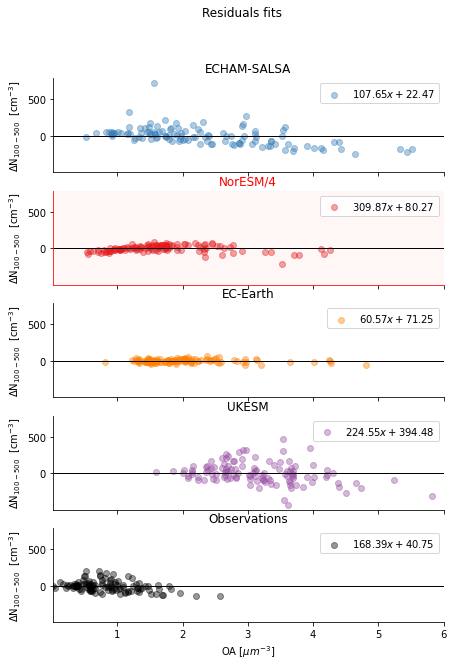

ECHAM-SALSA
[21.76245447 -7.04679775]
Beta: [ 24.42025324 -13.16100668]
Beta Std Error: [1.08787003 2.75167026]
Beta Covariance: [[ 10.68931825 -24.59054726]
 [-24.59054726  68.38939446]]
Residual Variance: 0.11071437710043626
Inverse Condition #: 0.13355010876483006
Reason(s) for Halting:
  Sum of squares convergence
[ 24.42025324 -13.16100668]
reason for haltng
NorESM
NorESM/4
[ 27.8531494  -19.64294251]
Beta: [ 29.22735631 -21.99384498]
Beta Std Error: [0.84212869 1.58155157]
Beta Covariance: [[ 14.82719987 -25.36539385]
 [-25.36539385  52.2960561 ]]
Residual Variance: 0.04782971355138195
Inverse Condition #: 0.16618786442708725
Reason(s) for Halting:
  Sum of squares convergence
[ 29.22735631 -21.99384498]
reason for haltng
EC-Earth
[40.86728059 -7.98935085]
Beta: [ 42.15642874 -10.68768978]
Beta Std Error: [0.97547484 2.21165   ]
Beta Covariance: [[ 30.58915864 -64.02667097]
 [-64.02667097 157.24186528]]
Residual Variance: 0.031107464332078363
Inverse Condition #: 0.13304472767782

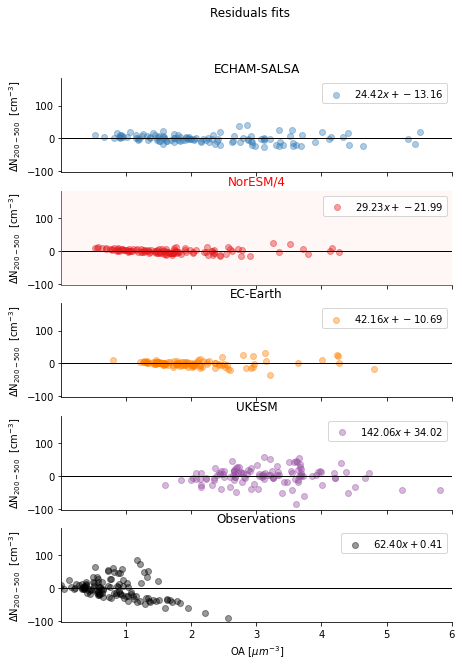

In [184]:
select_station = 'ATTO'

## Settings
alpha_scatt = 0.5


divide_NorESM_by_factor = 4


xlab = r'OA [$\mu m^{-3}$]'
alpha_scatt = 0.4
source_list = models_and_obs[::-1]
v_x = 'OA'

## Settings
dic_lims = {
    'N50': {'xlims':[.01,10], 'ylims':[1,5000]},
    'N100': {'xlims':[.01,10], 'ylims':[1,3000]},
    'N200': {'xlims':[.01,10], 'ylims':[1,200]},
    'N50-500': {'xlims':[.01,6], 'ylims':[1,5000]},
    'N100-500': {'xlims':[.01,6], 'ylims':[1,3000]},
    'N200-500': {'xlims':[.01,6], 'ylims':[1,200]},

}

dic_ylabels = {
    'N50' : r'$\Delta$N$_{50}$  [cm$^{-3}$]',
    'N100' : r'$\Delta$N$_{100}$  [cm$^{-3}$]',
    'N200' : r'$\Delta$N$_{200}$  [cm$^{-3}$]',
    'N50-500' : r'$\Delta$N$_{50-500}$  [cm$^{-3}$]',
    'N100-500' : r'$\Delta$N$_{100-500}$  [cm$^{-3}$]',
    'N200-500' : r'$\Delta$N$_{200-500}$  [cm$^{-3}$]',

}



xscale='linear'
yscale='linear'


# OBS: 
if select_station=='SMR':
    varlistplot = ['N50','N100','N200']
    
    dic_df_med = dic_df_med_SMR
    season = 'JA'
    func_station = func_smr
    divide_NorESM_by_factor = None
    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    season = 'FMA'
    func_station = func_atto
    
    divide_NorESM_by_factor = 4
    varlistplot = ['N50-500','N100-500','N200-500']



for i,v_y in enumerate(varlistplot):
    #dic_fits[select_station][v_y] = dict()
    fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)
    
    for mo, ax in zip(models_and_obs, axs):

        df_s =  dic_df_med[mo]
        print(mo)
        
        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        
        if (mo =='NorESM') &  (divide_NorESM_by_factor is not None):
            df_s = df_s/divide_NorESM_by_factor
            ax.set_facecolor('#fff6f6')
            title = f'{mo}/{divide_NorESM_by_factor}'
            print(title)
            ax.spines['bottom'].set_color('r')
            ax.spines['top'].set_color('r') 
            ax.spines['right'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.set_title(title, c='r')
        else:
            title=mo
            
            ax.set_title(title, )
    
        popt, pov, label, func = func_station(df_s,v_x,v_y)
        #legends_atto.append(label)


        _ma = df_s[v_x].max() 
        _mi = df_s[v_x].min() 
        ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
        #plt.show()
        xlims = dic_lims[v_y]['xlims']
        ax.set_yscale(yscale)
        ax.set_xscale(xscale)


        ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
        ax.legend(frameon=False)
        ylab = dic_ylabels[v_y]
        ax.set_ylabel(ylab)
        ax.set_xlim(xlims)
        ax.legend(frameon=True)

        
    #fig.suptitle('Observations')
    axs[-1].set_xlabel(xlab)
    fig.suptitle(r'Residuals fits')

    sns.despine(fig)    
    
    fn = make_fn_scat(f'residual_ln_{season}_{select_station}', v_x, v_y)
    fig.savefig(fn, dpi=150)
    fig.savefig(fn.with_suffix('.pdf'), dpi=150)
    print(fn)
    plt.show()

## Make plot for T to OA

In [185]:
def make_plot(v_x, v_y, xlims, ylims, season, 
              xlab=None, ylab=None, alpha_scat=.2,
             source_list = models_and_obs, fig=None, ax=None, daxs=None, axs_extra=None,
              xscale='linear', yscale='linear',
              dic_df_med = dic_df_med,
             ):
    if fig is None: 
        fig, ax, daxs, axs_extra = make_cool_grid3(ncols_extra=2, nrows_extra=3,)# w_ratio_sideplot=.5)

    if xlab is None: 
        if xlab in label_dic:
            xlab = label_dic[v_x]
    if ylab is None: 
        if ylab in label_dic:
            ylab = label_dic[v_y]

    for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()


        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt*.7, 
                    label='__nolegend__',
                    ax = ax,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                   )
        sns.scatterplot(x=v_x,y=v_y, 
                    data = df_s, 
                    color=cdic_model[mo], 
                    alpha=alpha_scatt+.1, 
                    label='__nolegend__',
                    ax = ax_ex,
                    #facecolor='none',
                    edgecolor=cdic_model[mo],
                        marker='.',
                    
                    
                   )
        ax_ex.set_title(mo,)
        
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    #fig.suptitle(f'{select_station}, {season} season, 2012-2018', y=.95)
    xlim_dist = list(daxs['y'].get_xlim())
    for mo in models_and_obs:

        df_s =  dic_df_med[mo]

        mask_months = select_months(df_s, season=season)
        df_s = df_s[mask_months].copy()
        if xscale=='log':
            xbins = np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),20)
        else:
            xbins = np.linspace(xlims[0],xlims[1],20)
            
        if yscale=='log':
            ybins = np.logspace(np.log10(ylims[0]),np.log10(ylims[1]),20)
        else:
            ybins = np.linspace(ylims[0],ylims[1],20)
            

        sns.histplot(#x=v_x,
                    x= df_s[v_x], 
            edgecolor=cdic_model[mo],
            #log_scale=(xscale=='log'),
            color=cdic_model[mo], 
            element="step",
            label=mo,
            linewidth=1,
            #log_scale=(xscale=='log',False,),

            alpha=.1,
            bins=xbins,
            ax = daxs['x'],
                    
                   )
        print(daxs['x'].get_ylim())
        _fi, ax_test = plt.subplots();
        ax_test = sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = ax_test,
            #ax = daxs['y'],
            linewidth=2,
            
            #edgecolor=None,
            #log_scale=(False,yscale=='log'),
            alpha=.1,
            bins=ybins,
        );
        
        sns.histplot(#x=v_x,
            y=df_s[v_y],
            color=cdic_model[mo], 
            element="step",
            label=mo,
            ax = daxs['y'],
            linewidth=1,
            
            #edgecolor=None,
            #log_scale=(xscale=='log',yscale=='log'),
            #log_scale=(False,yscale=='log'),
            
            alpha=.1,
            bins=ybins,
            )
        xlim_dist_n = list(ax_test.get_xlim())
        _fi.clf()
        #if xlim_dist_n[1]>xlim_dist_n[1]:
        xlim_dist[1] = max(xlim_dist_n[1],xlim_dist[1])
        #daxs['y'].set_xlim([0,xlim_dist[1]])
        
        #plt.show()

    ax.set_ylim(ylims)
    ax.set_xlim(xlims)


    for ax_e in axs_extra:
        ax_e.set_xlabel('')
        ax_e.set_ylabel('')
        ax_e.set_ylim(ax.get_ylim())
        ax_e.set_xlim(ax.get_xlim())
        ax_e.axes.xaxis.set_ticklabels([])
        ax_e.axes.yaxis.set_ticklabels([])

        sns.despine(ax = ax_e)

    return

#### WET_mid

[8.25, 8.25]


(<Figure size 825x825 with 14 Axes>,
 <AxesSubplot:>,
 {'x': <AxesSubplot:>, 'y': <AxesSubplot:>},
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

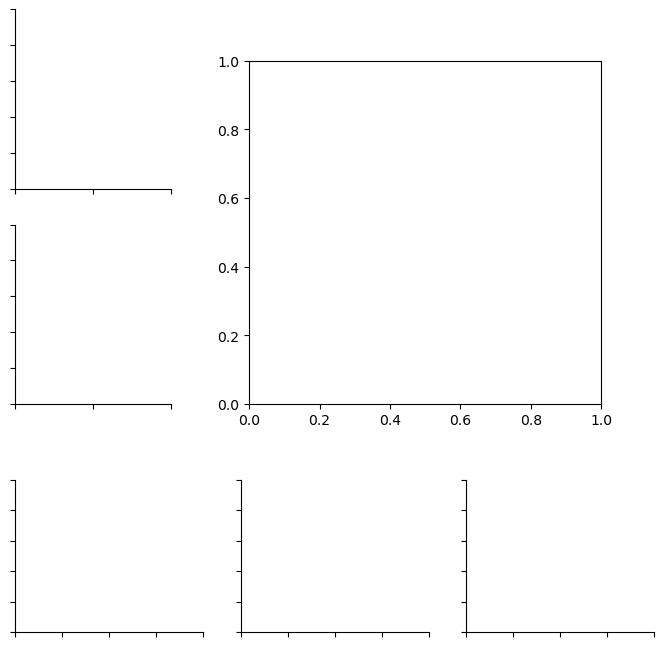

In [186]:
def make_cool_grid6(
    figsize=None,
    fig = None, 
    width_ratios=None,
    ncols=1,
    nrows=1,
    num_subplots_per_big_plot=2,
    size_big_plot=5,
    add_gs_kw=None,
    sharex='col',
    sharey='row',

    w_plot = 5.,
    w_cbar = 1,
    w_ratio_sideplot = 0.6,
    frac_dist_axis_from_big = .15
):
    width_small_plot = size_big_plot/(num_subplots_per_big_plot)
    width_dist_ax = size_big_plot*frac_dist_axis_from_big

    if figsize is None:
        figsize = [size_big_plot + width_small_plot+ width_dist_ax,
                   size_big_plot + width_small_plot+ width_dist_ax,
                   ]
        print(figsize)
    #width_ratios = None
    add_gs_kw = None

    #if width_ratios is None:
    #    width_ratios = [1] * ncols + [w_cbar / w_plot] #+ [1]* ncols_extra
    if add_gs_kw is None:
        add_gs_kw = dict()


    if 'hspace' not in add_gs_kw.keys():
        add_gs_kw['hspace'] = 0
    if 'wspace' not in add_gs_kw.keys():
        add_gs_kw['wspace'] = 0
    if fig is None:
        fig = plt.figure(figsize=figsize,
                     dpi=100)

    w_r1 = [size_big_plot,size_big_plot*frac_dist_axis_from_big]
    h_r1 = [frac_dist_axis_from_big,1, ]
    
    width_ratio_big_small = [size_big_plot+width_dist_ax,width_small_plot][::-1]
    height_ratio_big_small = [size_big_plot+width_dist_ax,width_small_plot]
    
    gs0 = gridspec.GridSpec(2, 2, figure=fig, height_ratios=height_ratio_big_small ,
                            width_ratios = width_ratio_big_small)
    # Big plot:
    gs00 = gridspec.GridSpecFromSubplotSpec(nrows+1, ncols+1, width_ratios=w_r1, height_ratios=h_r1, subplot_spec=gs0[0,1], **add_gs_kw)
    # for the small plots:
    gs01 = gridspec.GridSpecFromSubplotSpec(num_subplots_per_big_plot,2,width_ratios =[40,1], subplot_spec=gs0[:-1,0])#, **add_gs_kw)
    gs03 = gridspec.GridSpecFromSubplotSpec(2,num_subplots_per_big_plot+1, height_ratios =[1,40], subplot_spec=gs0[1,:])#, **add_gs_kw)
    # Axs for big plot and distribution axis:
    axs = gs00.subplots(sharex=sharex, sharey=sharey, )
    # Axes 
    axs_extra_sup = gs01.subplots(sharex=sharex, sharey=sharey, )
    axs_extra2_sup = gs03.subplots(sharex=sharex, sharey=sharey, )
    axs_extra = axs_extra_sup[:,0]
    axs_extra2 = axs_extra2_sup[1,:]
    for _ax in (list(axs_extra_sup[:,1].flatten())+list(axs_extra2_sup[0,:].flatten())) :
        _ax.axis("off")
        
    axs_extra = np.concatenate((axs_extra, axs_extra2[::-1],))
    
    axs[0,1].clear()
    axs[0,1].axis("off")
    daxs = dict(x=axs[0,0],y=axs[1,1])
    # distribution axis
    for a in daxs:
        _ax = daxs[a]
        sns.despine(bottom=False, left=False, ax=_ax)
        _ax.axis("off")
    # big plot!
    ax = axs[1,0]

    for ax_e in axs_extra:
        ax_e.set_xlabel('')
        ax_e.set_ylabel('')
        ax_e.set_ylim(ax.get_ylim())
        ax_e.set_xlim(ax.get_xlim())
        ax_e.axes.xaxis.set_ticklabels([])
        ax_e.axes.yaxis.set_ticklabels([])

        sns.despine(ax = ax_e)


    return fig, ax, daxs, axs_extra
make_cool_grid6()

In [187]:
from bs_fdbck.util.BSOA_datamanip.fits import get_least_square_fit_and_labs

In [188]:
def get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12]):
    v_log_y = f'ln({v_y})'
    df_s[v_log_y] = np.log(df_s[v_y])
    popt, pov, label, func_lin = get_odr_fit_and_labs(df_s, v_x, v_log_y, fit_func = 'linear', return_func=True, beta0=beta0)
    print('****ignore****')
    _, _, _, func = get_odr_fit_and_labs(df_s, v_x, v_log_y, fit_func = 'exp', return_func=True, beta0=beta0, pprint=False)
    print('****stop ignore****')
    popt_lin = popt
    a = np.exp(popt[-1])
    b = popt[0]
    
    if np.abs(a)< 0.009:
        #a_lab = ((str("%.2e" % a)).replace("e", ' \\cdot 10^{ ')).replace("+0", ") + ' } ')
        label = '($%.1E) \cdot e^{%5.2fx}$' %(a,b,)
    else:
        label = '$%5.2f e^{%5.2fx}$' %(a,b,)
    popt = [a,b]

    return popt, pov, label, func, func_lin, popt_lin

In [189]:
def get_r2_logy(df_s,v_x,x_y, popt, func):
    v_log_y = f'ln({v_y})'
    df_s[v_log_y] = np.log(df_s[v_y])
    _df = df_s[[v_x, v_log_y]].dropna().copy()
    y_pred = func(_df[v_x].values, *popt)
    r2 =  r2_score(_df[v_log_y].values, y_pred)
    return r2

(0.0, 47.25)
(0.0, 47.25)
(0.0, 52.5)
(0.0, 52.5)
(0.0, 52.5)
******ECHAM-SALSA*********
ECHAM-SALSA
[0.01, 0.12]
Beta: [ 0.23021082 -4.06577112]
Beta Std Error: [0.01074978 0.190172  ]
Beta Covariance: [[ 0.00049171 -0.00857277]
 [-0.00857277  0.15388659]]
Residual Variance: 0.23501326238205122
Inverse Condition #: 0.07332355188875521
Reason(s) for Halting:
  Sum of squares convergence
[ 0.23021082 -4.06577112]
reason for haltng
****ignore****
[0.01, 0.12]
[1.94392899e-14 1.44598381e+00]
reason for haltng
****stop ignore****
R2*****
0.5338331691640609
******NorESM*********
NorESM
[0.01, 0.12]
Beta: [ 0.17686144 -2.41096881]
Beta Std Error: [0.00774685 0.12717236]
Beta Covariance: [[ 0.00028615 -0.00458105]
 [-0.00458105  0.07711425]]
Residual Variance: 0.20972529419671193
Inverse Condition #: 0.10244339557144454
Reason(s) for Halting:
  Sum of squares convergence
[ 0.17686144 -2.41096881]
reason for haltng
****ignore****
[0.01, 0.12]
[0.0010082  0.34488732]
reason for haltng
****stop 

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_71356/2522199236.py:232: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
/tmp/ipykernel_71356/2522199236.py:233: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig_main.savefig(fn.with_suffix('.png'), dpi=200)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not app

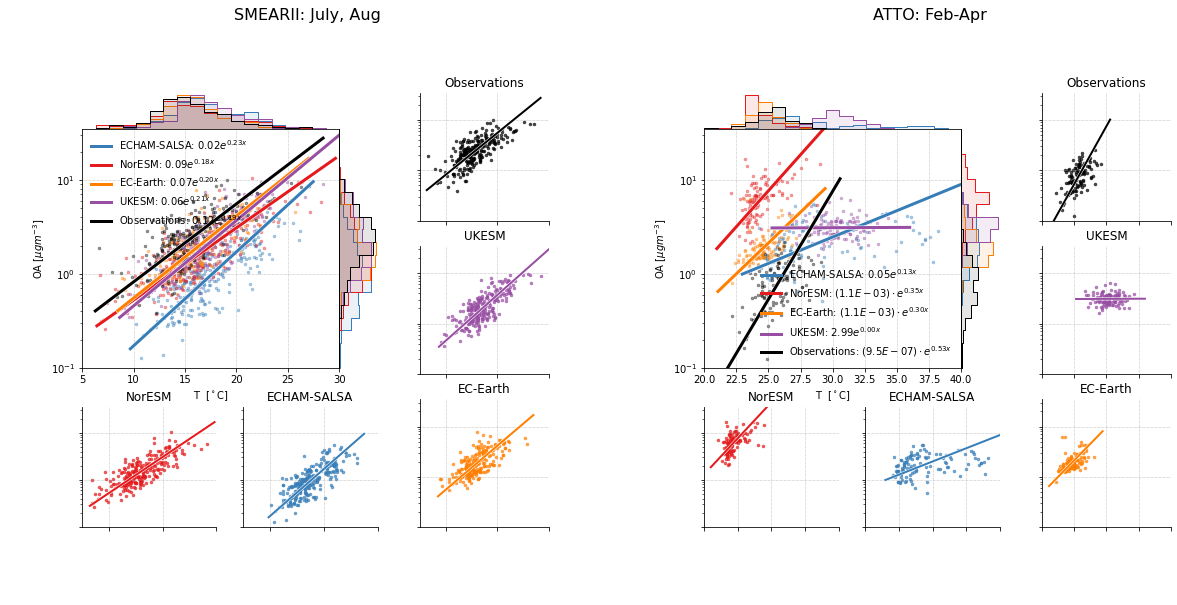

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [190]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17, 8.25],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'FMA'
season_smr = 'JA'





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO


## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')


for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

    
ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)
print(fn)
fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df_OA = df
df.to_csv(fn.with_suffix('.csv'))


In [191]:
df_OA

Fit  \
station variable data source                                  
SMR     OA       ECHAM-SALSA             $ 0.02 e^{ 0.23x}$   
                 NorESM                  $ 0.09 e^{ 0.18x}$   
                 EC-Earth                $ 0.07 e^{ 0.20x}$   
                 UKESM                   $ 0.06 e^{ 0.21x}$   
                 Observations            $ 0.12 e^{ 0.19x}$   
ATTO    OA       ECHAM-SALSA             $ 0.05 e^{ 0.13x}$   
                 NorESM        ($1.1E-03) \cdot e^{ 0.35x}$   
                 EC-Earth      ($1.1E-03) \cdot e^{ 0.30x}$   
                 UKESM                   $ 2.99 e^{ 0.00x}$   
                 Observations  ($9.5E-07) \cdot e^{ 0.53x}$   

                                                     a  \
station variable data source                             
SMR     OA       ECHAM-SALSA   1.71E-02 $\pm$ 2.22E-02   
                 NorESM        8.97E-02 $\pm$ 1.69E-02   
                 EC-Earth      7.41E-02 $\pm$ 2.05E-02   
                 UKESM         5.63E-02 $\pm$ 2.02E-02   
                 Observations          0.12 $\pm$ 0.02   
ATTO    OA       ECHAM-SALSA   5.12E-02 $\pm$ 2.07E-02   
                 NorESM        1.12E-03 $\pm$ 5.28E-02   
                 EC-Earth      1.11E-03 $\pm$ 4.56E-02   
                 UKESM                 2.99 $\pm$ 0.01   
                 Observations  9.52E-07 $\pm$ 7.82E-02   

                                                     b c r$^2$  
station variable data source                                    
SMR     OA       ECHAM-SALSA           0.23 $\pm$ 0.39    0.53  
                 NorESM                0.18 $\pm$ 0.28    0.58  
                 EC-Earth              0.20 $\pm$ 0.33    0.41  
                 UKESM                 0.21 $\pm$ 0.35    0.56  
                 Observations          0.19 $\pm$ 0.30    0.45  
ATTO    OA       ECHAM-SALSA           0.13 $\pm$ 0.60   -0.37  
                 NorESM                0.35 $\pm$ 1.29    0.03  
                 EC-Earth              0.30 $\pm$ 1.13   -0.02  
                 UKESM         1.25E-03 $\pm$ 4.52E-01     0.0  
                 Observations          0.53 $\pm$ 2.00    0.19

In [192]:
df_all = pd.concat([df_log, df_linear, df_OA], axis=0)


df_all['full_fit'] = df_all['Fit'].copy()
df_all = df_all.reset_index()
for i in df_all.index:
    #print(i)
    #print(df_all.loc[i,'Fit'].values[0])
    if 'ln' in df_all.loc[i,'Fit']:
        df_all.loc[i,'Fit'] = '$a+b\ln{(c+x)}$'

    elif 'e^' in df_all.loc[i,'Fit']:
        df_all.loc[i,'Fit'] = '$a\cdot \exp{(bx)}$'
    else:
        df_all.loc[i,'Fit'] = '$ax +b$'
df_all = (df_all
          .sort_values(['station','variable','data source','Fit'], ascending=False)
          .set_index(['station','variable','data source','Fit'])        
         )
df_all.to_csv('Plots/Both_stations/all_fits.csv')

In [193]:
df_all

a  \
station variable data source  Fit                                            
SMR     OA       UKESM        $a\cdot \exp{(bx)}$  5.63E-02 $\pm$ 2.02E-02   
                 Observations $a\cdot \exp{(bx)}$          0.12 $\pm$ 0.02   
                 NorESM       $a\cdot \exp{(bx)}$  8.97E-02 $\pm$ 1.69E-02   
                 ECHAM-SALSA  $a\cdot \exp{(bx)}$  1.71E-02 $\pm$ 2.22E-02   
                 EC-Earth     $a\cdot \exp{(bx)}$  7.41E-02 $\pm$ 2.05E-02   
...                                                                    ...   
ATTO    N100-500 NorESM       $ax +b$                     309.9 $\pm$ 40.5   
                 ECHAM-SALSA  $ax +b$                     107.6 $\pm$ 16.6   
                              $ax +b$                     107.6 $\pm$ 16.6   
                 EC-Earth     $ax +b$                       60.6 $\pm$ 8.1   
                              $ax +b$                       60.6 $\pm$ 8.1   

                                                                   b c  r$^2$  \
station variable data source  Fit                                               
SMR     OA       UKESM        $a\cdot \exp{(bx)}$    0.21 $\pm$ 0.35     0.56   
                 Observations $a\cdot \exp{(bx)}$    0.19 $\pm$ 0.30     0.45   
                 NorESM       $a\cdot \exp{(bx)}$    0.18 $\pm$ 0.28     0.58   
                 ECHAM-SALSA  $a\cdot \exp{(bx)}$    0.23 $\pm$ 0.39     0.53   
                 EC-Earth     $a\cdot \exp{(bx)}$    0.20 $\pm$ 0.33     0.41   
...                                                              ... ..   ...   
ATTO    N100-500 NorESM       $ax +b$              160.5 $\pm$ 152.4     0.96   
                 ECHAM-SALSA  $ax +b$                22.5 $\pm$ 41.0    -0.13   
                              $ax +b$                22.5 $\pm$ 41.0    -0.13   
                 EC-Earth     $ax +b$                71.2 $\pm$ 18.2     0.82   
                              $ax +b$                71.2 $\pm$ 18.2     0.82   

                                                             full_fit  
station variable data source  Fit                                      
SMR     OA       UKESM        $a\cdot \exp{(bx)}$  $ 0.06 e^{ 0.21x}$  
                 Observations $a\cdot \exp{(bx)}$  $ 0.12 e^{ 0.19x}$  
                 NorESM       $a\cdot \exp{(bx)}$  $ 0.09 e^{ 0.18x}$  
                 ECHAM-SALSA  $a\cdot \exp{(bx)}$  $ 0.02 e^{ 0.23x}$  
                 EC-Earth     $a\cdot \exp{(bx)}$  $ 0.07 e^{ 0.20x}$  
...                                                               ...  
ATTO    N100-500 NorESM       $ax +b$               $309.87x+ 160.55$  
                 ECHAM-SALSA  $ax +b$                $107.65x+ 22.47$  
                              $ax +b$                $107.65x+ 22.47$  
                 EC-Earth     $ax +b$                 $60.57x+ 71.25$  
                              $ax +b$                 $60.57x+ 71.25$  

[70 rows x 5 columns]

ECHAM-SALSA
[0.01, 0.12]
Beta: [ 0.23021082 -4.06577112]
Beta Std Error: [0.01074978 0.190172  ]
Beta Covariance: [[ 0.00049171 -0.00857277]
 [-0.00857277  0.15388659]]
Residual Variance: 0.23501326238205122
Inverse Condition #: 0.07332355188875521
Reason(s) for Halting:
  Sum of squares convergence
[ 0.23021082 -4.06577112]
reason for haltng
****ignore****
[0.01, 0.12]
[1.94392899e-14 1.44598381e+00]
reason for haltng
****stop ignore****


ValueError: too many values to unpack (expected 4)

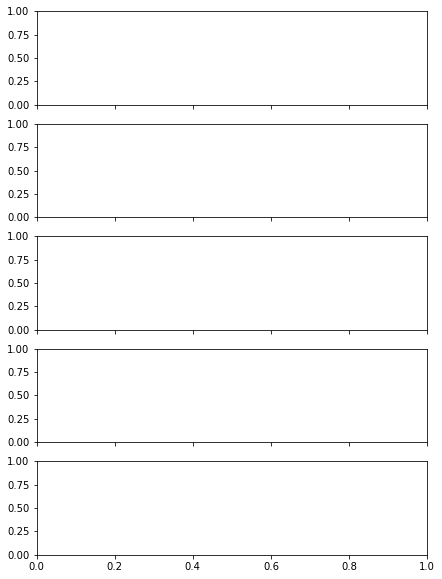

In [194]:
select_station = 'SMR'

if select_station=='SMR':
    dic_df_med = dic_df_med_SMR
    xlims = [5,30]
    season = 'JA'

    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    xlims = [20,40]
    season = 'JFM'
    
## Settings
alpha_scatt = 0.5

figsize=[7,10]
xlab = r'T  [$^\circ$C]'
ylab = r'$\Delta$OA [$\mu m^{-3}$]'


#ylims = [1,700]

# OBS: 
v_y = 'OA'
v_x = 'T_C'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6


for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True)
    popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)
    ax.set_title(mo, y=.93)
    ax.set_xlim(xlims)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
fig.suptitle(r'Residuals fits')

sns.despine(fig)    
    
fn = make_fn_scat(f'residual_exp_{season}_{select_station}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

In [ ]:
select_station = 'ATTO'

if select_station=='SMR':
    dic_df_med = dic_df_med_SMR
    xlims = [5,30]
    season = 'JA'

    
elif select_station=='ATTO':
    dic_df_med = dic_df_med_ATTO
    xlims = [20,40]
    season = 'JFM'
    
## Settings
alpha_scatt = 0.5

figsize=[7,10]
xlab = r'T  [$^\circ$C]'
ylab = r'$\Delta$OA [$\mu m^{-3}$]'


#ylims = [1,700]

# OBS: 
v_y = 'OA'
v_x = 'T_C'


xscale='linear'
yscale='linear'

fig, axs = plt.subplots(len(models_and_obs), sharex=True, sharey= True, figsize=figsize)

## Settings
alpha_scatt = 0.6


for mo, ax in zip(models_and_obs, axs):
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func, out = get_odr_fit_and_labs(df_s,v_x,v_y, fit_func='linear', return_func=True, return_out_obj=True)
    #popt, pov, label, func = get_log_fit_abc(df_s,v_x,v_y, return_func=True)
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True)
    popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    ax.scatter(df_s[v_x],df_s[v_y]-func(df_s[v_x],*popt),
                                    color=cdic_model[mo], 
                #alpha=alpha_scatt, 
                #facecolor='none',
               alpha=alpha_scatt,
               
                edgecolor=cdic_model[mo],

                label=label
                   )
    _xlim = [_mi*.95, _ma*1.05]
    ax_ex.set_yscale(yscale)
    ax_ex.set_xscale(xscale)


    ax.hlines(0, xmin=xlims[0],xmax=xlims[1], color='k', linewidth=1)
    ax.legend(frameon=False)
    ax.set_ylabel(ylab)
    ax.set_title(mo, y=.93)
    ax.set_xlim(xlims)

        
#fig.suptitle('Observations')
axs[-1].set_xlabel(xlab)
fig.suptitle(r'Residuals fits')

sns.despine(fig)    
    
fn = make_fn_scat(f'residual_exp_{season}_{select_station}', v_x, v_y)
ax.legend(frameon=False)
fig.savefig(fn, dpi=150)
fig.savefig(fn.with_suffix('.pdf'), dpi=150)
print(fn)

## JFMAM

In [ ]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17, 8.25],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'JFMAM'
season_smr = 'JA'





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO


## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')


for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

    
ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
#subfig_up_atto.suptitle('ATTO: Feb, Mar, Apr, May',size=16,)
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)
print(fn)
fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df_OA = df
df.to_csv(fn.with_suffix('.csv'))


## JFM

In [ ]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17, 8.25],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'JFM'
season_smr = 'JA'





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO


## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')


for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

    
ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
#subfig_up_atto.suptitle('ATTO: Feb, Mar, Apr, May',size=16,)
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)
print(fn)
fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df_OA = df
df.to_csv(fn.with_suffix('.csv'))


## MAM

In [ ]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17, 8.25],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'MAM'
season_smr = 'JA'





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO


## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')


for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

    
ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
#subfig_up_atto.suptitle('ATTO: Feb, Mar, Apr, May',size=16,)
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)
print(fn)
fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df_OA = df
df.to_csv(fn.with_suffix('.csv'))


## FMAM

In [ ]:
fig_main = plt.figure(constrained_layout=True,
                  figsize=[17, 8.25],
                 )
spec2 = gridspec.GridSpec( nrows=2,ncols=3, 
                          height_ratios=[1,30], 
                          width_ratios=[30,1,30], 
                          figure=fig_main)

subfig_smr =  fig_main.add_subfigure(spec2[1, 0],frameon=True)
subfig_atto =  fig_main.add_subfigure(spec2[1, 2],frameon=True)
subfig_up_smr =  fig_main.add_subfigure(spec2[0, 0])
subfig_up_atto =  fig_main.add_subfigure(spec2[0, 2])



dic_fits = {}
dic_fits['SMR'] =dict()
dic_fits['ATTO'] =dict()



season_atto = 'FMAM'
season_smr = 'JA'





fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_smr )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]








dic_df_med = dic_df_med_SMR
select_station = 'SMR'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()

## Settings
alpha_scatt = 0.6

xlab = r'T  [$^\circ$C]'
ylab = r'OA [$\mu g m^{-3}$]'


linewidth=2
xlims = [5,30]
ylims = [.1,35]


season=season_smr
v_x = 'T_C'
v_y = 'OA'
dic_fits[select_station][v_y] = dict()


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}*********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func,func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])

    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')

for ax_ex in axs_extra:
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)

    
fn = make_fn_scat(f'exp1_{season}', v_x, v_y)
ax.legend(frameon=False)




## ATTO:
select_station = 'ATTO'
dic_fits[select_station] = dict()
dic_fits[select_station][v_y] = dict()


xlims = [20,40]



fig, ax, daxs, axs_extra = make_cool_grid5(fig =subfig_atto )##ncols_extra=2, nrows_extra=2,)# w_ratio_sideplot=.5)

axs_extra = axs_extra.flatten()[::-1]

dic_df_med = dic_df_med_ATTO


## Settings
alpha_scatt = 0.6


linewidth=2
xlims = [20,40]


season = season_atto


make_plot(v_x, v_y, xlims, ylims, season, 
              xlab, ylab, .3, models_and_obs, fig, ax, daxs, axs_extra,
          yscale='log',
          dic_df_med = dic_df_med
         
         )


for mo, ax_ex in zip(models_and_obs, axs_extra[:]):
    print(f'******{mo}********')
    df_s =  dic_df_med[mo]
    print(mo)
    mask_months = select_months(df_s, season=season)
    df_s = df_s[mask_months].copy()
    
    #popt, pov, label, func = get_least_square_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    #popt, pov, label, func = get_odr_fit_and_labs(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
    popt, pov, label, func, func_lin, popt_lin = get_lin_log_fit(df_s, v_x, v_y, fit_func = 'exp', return_func=True, beta0=[0.01,.12])
        
    dic_fits[select_station][v_y][mo] = dict()
    dic_fits[select_station][v_y][mo]['label'] = label
    dic_fits[select_station][v_y][mo]['popt'] = popt
    dic_fits[select_station][v_y][mo]['pcov'] = pov
    dic_fits[select_station][v_y][mo]['standard_error'] = np.sqrt(np.diag(dic_fits[select_station][v_y][mo]['pcov']))

    dic_fits[select_station][v_y][mo]['func'] = func
    dic_fits[select_station][v_y][mo]['r2'] = get_r2_logy(df_s,v_x,v_y, popt_lin, func_lin)
    print('R2*****')
    print(dic_fits[select_station][v_y][mo]['r2'])
    
    dic_fits[select_station][v_y][mo] = calc_table_se(dic_fits[select_station][v_y][mo])   

    
    
    _mi = df_s[v_x].min()
    _ma = df_s[v_x].max() 
    _xlim = [_mi*.95, _ma*1.05]
    x = np.linspace(*_xlim)
    
    ax.plot(x, func(x, *popt), c='w', linewidth=linewidth+2,label='__nolegend__')
    ax.plot(x, func(x, *popt), linewidth=linewidth+1, c=cdic_model[mo],label=f'{mo}: {label}')

    ax_ex.plot(x, func(x, *popt), c='w', linewidth=linewidth+1,label=f'{mo}: {label}',
             )
    ax_ex.plot(x, func(x, *popt), c=cdic_model[mo],label=f'{mo}: {label}',
               linewidth=linewidth,
              )
    ax_ex.set_yscale('log')
    ax_ex.set_ylim(ylims)
    ax_ex.set_xlim(xlims)
ax.set_yscale('log')
ax.grid(color='grey', linewidth=.5, linestyle=':')


for ax_ex in axs_extra.flatten():
    ax_ex.set_yticklabels([])
    ax_ex.grid(color='grey', linewidth=.5, linestyle=':')

    
ax.legend(frameon=False)











ax_up_smr = subfig_up_smr.subplots()
ax_up_smr.axis('off')
subfig_up_smr.suptitle('SMEARII: July, Aug',size=16,)
ax_up_atto = subfig_up_atto.subplots()
ax_up_atto.axis('off')
#subfig_up_atto.suptitle('ATTO: Feb, Mar, Apr, May',size=16,)
subfig_up_atto.suptitle(f'ATTO: {dic_season_nicename[season_atto]}',size=16,)

fn = make_fn_scat(f'together_{season_smr}_{season_atto}', v_x, v_y)

print(fn)
fig_main.savefig(fn.with_suffix('.pdf'), dpi=200)
fig_main.savefig(fn.with_suffix('.png'), dpi=200)
plt.show()

df = make_pd_of_dic(dic_fits)
df_OA = df
df.to_csv(fn.with_suffix('.csv'))


In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10, 4),)
subfigs = fig.subfigures(1, 3, width_ratios=[4,1,4], wspace=0.07)


f1 = subfigs[0]
f1.subplots(3,5, sharex=True, sharey='row')
subfigs[2].subplots(3,5, sharex=True, sharey='row')
subfigs[1].subplots(3,1, sharex=True, sharey='row')
subfigs[0].set_facecolor('#e5f8f8')
subfigs[-1].set_facecolor('#fff4ea')
subfigs[0].suptitle('SMEARII, Jul & Aug')
subfigs[-1].suptitle('ATTO, JFM')
#subfigs[1].suptitle('Fits')
#fig.set_constrained_layout_pads(h_pad=1, w_pad = 1)
#fig.tight_layout()
plt.show()


In [ ]:
fig, axs_all = plt.subplots(3,11,figsize=[20,10], sharey='row', sharex='col')

for ax in axs_all[:,:5].flatten():
    ax.set(facecolor = "#fff4ea",)#a4c8d6")
    #ax.patch.set_facecolor('orange')
for ax in axs_all[:,6:].flatten():
    ax.set(facecolor = "#e5f8f8",)#a4c8d6")
    #ax.patch.set_facecolor('orange')


In [ ]:
fig, axs_all = plt.subplots(3,11,figsize=[20,10], sharey='row', sharex='col')

for ax in axs_all[:,:5].flatten():
    ax.set(facecolor = "#d0d6c4",)#a4c8d6")
    #ax.patch.set_facecolor('orange')
for ax in axs_all[:,6:].flatten():
    ax.set(facecolor = "#f1f8e3",)#a4c8d6")
    #ax.patch.set_facecolor('orange')


In [ ]:
fig, axs_all = plt.subplots(3,6,figsize=[10,10], sharey='row', sharex='col')
